In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import ast

schools = pd.read_csv('school_genres.csv')
# PageRank for school genres
# first encode in sparse matrix rep
schools.head()

,Unnamed: 0,SCHOOL,GENRES,PLAYLIST_LINK
0,0,Texas A & M University-College Station,"['reddirt', 'outlawcountry', 'texascountry', '...",https://embed.spotify.com/?uri=spotify:playlis...
1,1,The University of Texas at Austin,"['modernrock', 'indiepop', 'pop', 'indiepoptim...",https://embed.spotify.com/?uri=spotify:playlis...
2,2,Ohio State University-Main Campus,"['pop', 'indiepoptimism', 'modernrock', 'indie...",https://embed.spotify.com/?uri=spotify:playlis...
3,3,University of Central Florida,"['pop', 'poprap', 'rap', 'hiphop', 'electrohou...",https://embed.spotify.com/?uri=spotify:playlis...
4,4,Arizona State University-Tempe,"['edm', 'electrohouse', 'pop', 'electronictrap...",https://embed.spotify.com/?uri=spotify:playlis...


In [49]:
#
# Example, find all schools with colorado and view top 5 genres
#

co = schools[schools['SCHOOL'].str.contains('Colorado')]
for idx,row in co.iterrows():
    ranking = ast.literal_eval(row['GENRES'])[:5]
    print(row['SCHOOL'])
    print(ranking)

University of Colorado Boulder
['edm', 'electronictrap', 'electrohouse', 'brostep', 'indiepoptimism']
Colorado State University-Fort Collins
['edm', 'modernrock', 'indiepoptimism', 'electrohouse', 'electronictrap']
University of Colorado Denver/Anschutz Medical Campus
['edm', 'electrohouse', 'electronictrap', 'indiepoptimism', 'brostep']
University of Colorado Colorado Springs
['edm', 'indiepoptimism', 'electronictrap', 'electrohouse', 'pop']
University of Northern Colorado
['indiepoptimism', 'modernrock', 'edm', 'electronictrap', 'electrohouse']
Colorado Mesa University
['pop', 'edm', 'poprap', 'indiepoptimism', 'electrohouse']
Colorado School of Mines
['indiepoptimism', 'modernrock', 'indiepop', 'edm', 'indietronica']
Colorado Christian University
['anthemworship', 'indiecoustica', 'ccm', 'worship', 'christianuplift']


In [105]:
#
# Create graph for SpringRank
#

SRG = nx.DiGraph()
added_nodes = set({})
# node score will track count of nodes placement in rank for borda count
node_score = {}
for idx, row in schools.iterrows():
    ranking = ast.literal_eval(row['GENRES'])[:10]
    rank_set = set(ranking)
    for i in range(len(ranking)):
        new_top = ranking[i]
        # this is how we know the top spring ranked node was only in two schools rankings
        if new_top == 'pinoyindie':
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print(row['SCHOOL'])
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        try:
            node_score[new_top][len(ranking)-i]  += 1
        except:
            try:
                node_score[new_top][len(ranking)-i] = 1
            except:
                node_score[new_top] = {}
                node_score[new_top][len(ranking)-i] = 1
        if new_top not in added_nodes:
            G.add_node(new_top)
        rank_set.remove(new_top)
        edges = [(new_top, lower_node) for lower_node in rank_set]
        for e,v in edges:
            if SRG.has_edge(e,v):
                SRG[e][v]['weight'] += 1
            else:
                SRG.add_edge(e,v, weight = 1)
            
        # Useful if you only need a small sample (for testing mainly)
#     if idx == 10:
#         break

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saint Louis University
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Xavier University
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [116]:
#
# Create graph for PageRank
#

PRG = nx.DiGraph()
added_nodes = set({})
node_score = {}
for idx, row in schools.iterrows():
    ranking = ast.literal_eval(row['GENRES'])[:10]
    rank_set = set(ranking)
    for i in range(len(ranking)):
        new_top = ranking[i]
        if new_top == 'pinoyindie':
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print(row['SCHOOL'])
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        try:
            node_score[new_top][len(ranking)-i]  += 1
        except:
            try:
                node_score[new_top][len(ranking)-i] = 1
            except:
                node_score[new_top] = {}
                node_score[new_top][len(ranking)-i] = 1
        if new_top not in added_nodes:
            G.add_node(new_top)
        rank_set.remove(new_top)
        # only reverse the direction of the edge for PageRank, otherwise graph is the same
        edges = [(lower_node, new_top) for lower_node in rank_set]
        for e,v in edges:
            if PRG.has_edge(e,v):
                PRG[e][v]['weight'] += 1
            else:
                PRG.add_edge(e,v, weight = 1)
    


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saint Louis University
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Xavier University
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [117]:
pr = pd.Series(nx.pagerank(PRG))
pr

anthemworship          0.011848
reddirt                0.014471
moderncountryrock      0.019356
contemporarycountry    0.029330
indiecoustica          0.007998
                         ...   
jazzfusion             0.000919
mexicanpop             0.000584
christianindie         0.000574
trapespanol            0.000574
gospelrb               0.000748
Length: 269, dtype: float64

In [118]:
adj = nx.to_numpy_matrix(SRG)
nodes=list(SRG.nodes())

adj

matrix([[ 0., 27., 35., ...,  0.,  0.,  0.],
        [ 2.,  0., 14., ...,  1.,  0.,  0.],
        [12., 19.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [119]:
# https://github.com/cdebacco/SpringRank

import SpringRank_tools as sr
import tools as tl
network = 'schools'
alpha=0.
l0=1.
l1=1.
'''
Extracts SpringRank
'''
rank=sr.SpringRank(adj,alpha=alpha,l0=l0,l1=l1)

rank=tl.shift_rank(rank)   # (optional) shifts so that the min is in zero and the others are positive

'''
Order results so that the first node is the highest-ranked one
'''
X=[(nodes[i],rank[i]) for i in range(SRG.number_of_nodes())]
X= sorted(X, key=lambda tup: tup[1],reverse=True)
'''
Prints results
'''
print('SpringRank scores:')
for i in range(100):
    print("{} {}\n".format(X[i][0],X[i][1]))
    print(X[i][0],X[i][1])


SpringRank scores:
opm 2.7300489480143932

opm 2.7300489480143932
arabpop 2.570443637358184

arabpop 2.570443637358184
pinoyindie 2.5300486183514663

pinoyindie 2.5300486183514663
lebanesepop 2.370443307695189

lebanesepop 2.370443307695189
jewishpop 2.3466733503532633

jewishpop 2.3466733503532633
pinoyrock 2.3300482886884524

pinoyrock 2.3300482886884524
deepindianpop 2.2045381245290416

deepindianpop 2.2045381245290416
dabke 2.1704429780321806

dabke 2.1704429780321806
classicopm 2.130047959025473

classicopm 2.130047959025473
calirap 2.1028227875495356

calirap 2.1028227875495356
reddirt 2.0692907701069014

reddirt 2.0692907701069014
jawaiian 2.0191692776469043

jawaiian 2.0191692776469043
outlawcountry 2.0097707609079

outlawcountry 2.0097707609079
deepsoutherntrap 2.0059541502331824

deepsoutherntrap 2.0059541502331824
israelimediterranean 1.9455338129523418

israelimediterranean 1.9455338129523418
westcoasttrap 1.9169975199854274

westcoasttrap 1.9169975199854274
armenianpop 1.9

In [120]:
top_spring_genres = X[:75]
top_spring_genres = [g for g,s in top_spring_genres]

In [121]:
pr = pd.Series(nx.pagerank(PRG))
pr.nlargest(75).to_csv('top_school_genres_reverse.csv')

/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [122]:
pr.nlargest(75) # top pagerank genres

pop                    0.062252
poprap                 0.053595
rap                    0.050236
contemporarycountry    0.029330
indiepoptimism         0.027956
                         ...   
motown                 0.002697
alternativeemo         0.002499
rootsamericana         0.002488
russiandancepop        0.002458
jewishpop              0.002453
Length: 75, dtype: float64

In [123]:
scores = pd.DataFrame(node_score) # borda count

In [124]:
scores

,reddirt,outlawcountry,texascountry,anthemworship,indiecoustica,rootsamericana,ccm,countryroad,moderncountryrock,contemporarycountry,...,praise,naijaworship,contemporaryjazz,jazzfusion,contemporarypostbop,neorb,mexicanpop,christianindie,trapespanol,gospelrb
10,21,18,NaN,33,11,NaN,12,NaN,NaN,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,2,3.0,7,7,NaN,10,8.0,18.0,7,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7,2,2,NaN,14,6,2.0,2,16.0,25.0,23,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4,3.0,4,6,3.0,8,7.0,5.0,19,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN
4,7,1,4.0,2,7,NaN,16,10.0,9.0,4,...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,2,5,7.0,10,19,2.0,1,21.0,7.0,8,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,1,38.0,4,5,NaN,10,17.0,36.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,18,22,NaN,20,3,NaN,31,49.0,8.0,10,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,6,3.0,2,16,NaN,4,20.0,8.0,13,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,4,10,NaN,7,8,11.0,3,9.0,22.0,12,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [125]:
# give weight to ranking of each genres, 10*number1 count, 9 * number2 count, etc
for i in range(1,11):
    print(i)
    scores.loc[i] = scores.loc[i]*(11-i)

1
2
3
4
5
6
7
8
9
10


In [126]:
scored_set = set(scores.sum().nlargest(75).index.values)
pr_set = set(pr.nlargest(75).index.values)
sr_set = set(top_spring_genres)

In [127]:
#
# What do these ranking systems have in common?? 
#

print(scored_set.difference(pr_set))
print(pr_set.difference(scored_set))
print(len(scored_set & pr_set))


print(scored_set.difference(sr_set))
print(sr_set.difference(scored_set))
print(len(scored_set & sr_set))

print(pr_set.difference(sr_set))
print(sr_set.difference(pr_set))
print(len(pr_set & sr_set))

{'indiepoprap', 'soul', 'christianuplift', 'vaportwitch', 'chamberpop', 'deepccm', 'indierock', 'christianalternativerock', 'melodicrap', 'countryrock', 'vaporsoul', 'reggaerock', 'emo', 'traplatino', 'atlhiphop', 'zapstep', 'gangsterrap', 'dirtysouthrap', 'rootsworship'}
{'regionalmexican', 'classicsoul', 'lds', 'pinoyindie', 'jawaiian', 'arabpop', 'reggaetonflow', 'ldsyouth', 'dominicanpop', 'reggaeton', 'polynesianpop', 'russiandancepop', 'motown', 'dancehall', 'soca', 'detroittrap', 'jewishpop', 'filmi', 'opm'}
56
{'indierb', 'countrypop', 'christianmusic', 'alternativeemo', 'soul', 'alternativerb', 'indiepoprap', 'deeppoprb', 'brostep', 'christianuplift', 'escaperoom', 'latin', 'vaportwitch', 'worldworship', 'urbancontemporary', 'chamberpop', 'indiefolk', 'electropop', 'deepccm', 'indierock', 'christianalternativerock', 'indiepop', 'melodicrap', 'undergroundhiphop', 'popedm', 'countryrock', 'hiphop', 'vaporsoul', 'indiecoustica', 'stompandholler', 'reggaerock', 'rootsworship', 'em

In [128]:
scores.sum().nlargest(75).to_csv('top_genres_scored.csv')

/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [69]:
schools = pd.read_csv('school_genres.csv')
# PageRank for school genres
# first encode in sparse matrix rep
schools.head()

,Unnamed: 0,SCHOOL,GENRES,PLAYLIST_LINK
0,0,Texas A & M University-College Station,"['reddirt', 'outlawcountry', 'texascountry', '...",https://embed.spotify.com/?uri=spotify:playlis...
1,1,The University of Texas at Austin,"['modernrock', 'indiepop', 'pop', 'indiepoptim...",https://embed.spotify.com/?uri=spotify:playlis...
2,2,Ohio State University-Main Campus,"['pop', 'indiepoptimism', 'modernrock', 'indie...",https://embed.spotify.com/?uri=spotify:playlis...
3,3,University of Central Florida,"['pop', 'poprap', 'rap', 'hiphop', 'electrohou...",https://embed.spotify.com/?uri=spotify:playlis...
4,4,Arizona State University-Tempe,"['edm', 'electrohouse', 'pop', 'electronictrap...",https://embed.spotify.com/?uri=spotify:playlis...


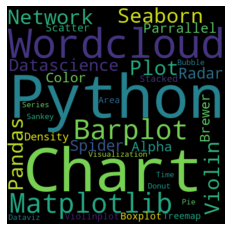

In [131]:
#
# Generate example wordcloud for presentation
#

from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text=("Python Python Python Matplotlib Matplotlib Seaborn Network Plot Violin Chart Pandas Datascience Wordcloud Spider Radar Parrallel Alpha Color Brewer Density Scatter Barplot Barplot Boxplot Violinplot Treemap Stacked Area Chart Chart Visualization Dataviz Donut Pie Time-Series Wordcloud Wordcloud Sankey Bubble")
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In [132]:
schools['SCHOOL'].sample(10)

25     California State University-Long Beach
660       University of Puerto Rico-Aguadilla
85                   James Madison University
642                  Berklee College of Music
380        Tennessee Technological University
323    California State University-Stanislaus
325                     Quinnipiac University
181                      Orange Coast College
583                       Lipscomb University
604             Southern Adventist University
Name: SCHOOL, dtype: object

In [133]:
school_name = ['Dartmouth','UCB','Princeton','CSU']
school_real = ['Dartmouth College','University of Colorado Boulder', 'Colorado State University-Fort Collins','Princeton University']

Dartmouth
Dartmouth College
['indiepoptimism', 'pop', 'modernrock', 'electropop', 'indiefolk', 'indiepop', 'folkpop', 'stompandholler', 'edm', 'popedm']
Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth Dartmouth indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism pop pop pop pop pop pop pop pop pop pop modernrock modernrock modernrock modernrock modernrock modernrock modernrock modernrock modernrock modernrock electropop electropop electropop electropop electropop electropop electropop electropop electropop electropop indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk indiepop indiepop indiepop indiepop indiepop indiepop indiepop indiepop indiepop indiepop folkpop folkpop folkpop folkpop folkpop folkpop folkpop folkpop folkpop folkpop stompandholler st

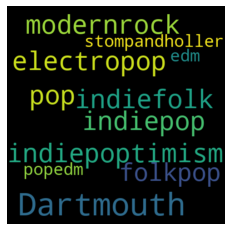

UCB
University of Colorado Boulder
['edm', 'electronictrap', 'electrohouse', 'brostep', 'indiepoptimism', 'vaporsoul', 'vaportwitch', 'electropop', 'modernrock', 'popedm']
UCB UCB UCB UCB UCB UCB UCB UCB UCB UCB UCB UCB UCB UCB UCB edm edm edm edm edm edm edm edm edm electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse brostep brostep brostep brostep brostep brostep brostep brostep brostep indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism vaporsoul vaporsoul vaporsoul vaporsoul vaporsoul vaporsoul vaporsoul vaporsoul vaporsoul vaportwitch vaportwitch vaportwitch vaportwitch vaportwitch vaportwitch vaportwitch vaportwitch vaportwitch electropop electropop electropop electropop electropop electropop electropo

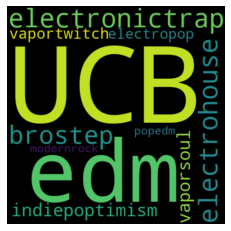

Princeton
Colorado State University-Fort Collins
['edm', 'modernrock', 'indiepoptimism', 'electrohouse', 'electronictrap', 'electropop', 'brostep', 'vaporsoul', 'vaportwitch', 'pop']
Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton Princeton edm edm edm edm edm edm edm edm modernrock modernrock modernrock modernrock modernrock modernrock modernrock modernrock indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse electrohouse electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electronictrap electropop electropop electropop electropop electropop electropop electropop electropop brostep brostep brostep brostep brostep brostep brostep brostep vaporsoul vaporsoul vaporsoul vaporsoul vaporsoul v

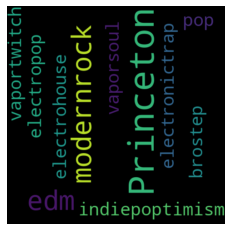

CSU
Princeton University
['modernrock', 'indiepop', 'folkpop', 'indiefolk', 'electropop', 'alternativerb', 'artpop', 'chamberpop', 'indiepoptimism', 'indierock']
CSU CSU CSU CSU CSU CSU CSU CSU CSU CSU CSU CSU CSU CSU CSU modernrock modernrock modernrock modernrock modernrock modernrock modernrock indiepop indiepop indiepop indiepop indiepop indiepop indiepop folkpop folkpop folkpop folkpop folkpop folkpop folkpop indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk indiefolk electropop electropop electropop electropop electropop electropop electropop alternativerb alternativerb alternativerb alternativerb alternativerb alternativerb alternativerb artpop artpop artpop artpop artpop artpop artpop chamberpop chamberpop chamberpop chamberpop chamberpop chamberpop chamberpop indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indiepoptimism indierock indierock indierock indierock indierock indierock indierock


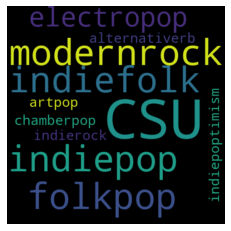

In [134]:
for i in range(4):
    print(school_name[i])
    print(school_real[i])
    text = 15*" {} ".format(school_name[i])
    row = schools[schools['SCHOOL']==school_real[i]]
    top_10 = ast.literal_eval(row['GENRES'].values[0])[:10]
    print(top_10)
    for j in range(10):
        text += (10-i)*" {} ".format(top_10[j])
    text = text.replace('  ',' ')
    text = text.strip()
    print(text)
    wordcloud = WordCloud(width=480, height=480, margin=0,collocations=False).generate(text)
 
# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.savefig(school_name[i]+'.png')
    plt.show()